<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson2_dft_surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get GPAW as we did last session
- GPAW(+dependencies+ASE)
- POVRAY

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

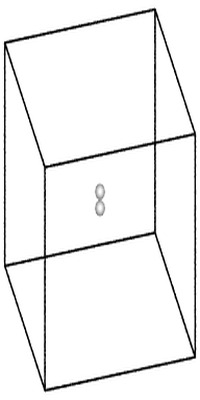

In [2]:
!apt-get update
!apt-get install -y python3-dev libopenblas-dev liblapack-dev libfftw3-dev libxc-dev
!pip install gpaw
!gpaw test
!wget https://wiki.fysik.dtu.dk/gpaw-files/gpaw-setups-24.1.0.tar.gz
!tar -xzf gpaw-setups-24.1.0.tar.gz

import os
import gzip
import shutil

# Define the path to the setup files
setup_path = '/content/gpaw-setups-24.1.0'

# Uncompress all .gz files in the setup directory
for filename in os.listdir(setup_path):
    if filename.endswith('.gz'):
        filepath = os.path.join(setup_path, filename)
        with gzip.open(filepath, 'rb') as f_in:
            with open(filepath[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

# Set the GPAW_SETUP_PATH environment variable
os.environ['GPAW_SETUP_PATH'] = setup_path
# Verify the environment variable
print("GPAW_SETUP_PATH:", os.environ['GPAW_SETUP_PATH'])

# Import ASE and GPAW and run your calculation
from ase import Atoms
from gpaw import GPAW

# Define the atomic structure
d = 0.74
a = 10.0

h2 = Atoms('H2',
              positions=[(0, 0, 0),
                         (0, 0, d)],
              cell=(a, a, a))
h2.center()
# Initialize GPAW calculator without specifying the 'setups' parameter
calc = GPAW(mode='fd', nbands=2, txt='h2.txt')
h2.calc = calc

# Run the calculation
print("Forces on atoms:", h2.get_forces())
print("Energies on atoms:", h2.get_total_energy())

!sudo apt-get install povray  ## visulization program

import os
import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=2.0, rotation='15z,-60x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))
visual(h2)

## Lets make a catalyst surface using ase.build library

Atomic numbers: [13 13 13 13]
Chemical symbols: ['Al', 'Al', 'Al', 'Al']
Positions: [[ 1.41421356  1.41421356  7.5       ]
 [ 0.          0.          9.5       ]
 [ 1.41421356  1.41421356 11.5       ]
 [ 0.          0.         13.5       ]]
Potential Energy: -25.481157004886242 eV
Time taken: 29.37 seconds
Atoms(symbols='Al4', pbc=[True, True, False], cell=[2.8284271247461903, 2.8284271247461903, 21.0], tags=..., constraint=FixAtoms(indices=[0, 1]), calculator=GPAW(...))


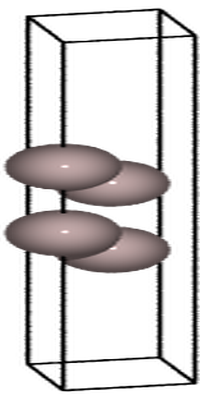

'temp=surf.copy()\ntemp=temp*(3,3,1)\ntemp.cell=surf.cell\nvisual(temp)'

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase import Atoms
from gpaw import GPAW, PW
from ase.build import fcc100
from ase.constraints import FixAtoms


# Initialize the parameters
a0 = 4 #lattice constant from EOS optimization
k = 1 # KPOINTS
N_layer = 4 # number of layers
size = 1 #  supercell size
vac = 7.5

surf = fcc100('Al', (size, size, N_layer), a=a0, vacuum=vac)
#surf.center(axis=2)

# Calculate the median z-position
median_z = np.median(surf.positions[:, 2])

# Apply the constraint to fix atoms below the median z position
constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
surf.set_constraint(constraint)

# Set up the GPAW calculator
calc = GPAW(mode=PW(300),
            kpts=(k, k, 1),
            txt='slab-%d.txt')
# Attach the calculator to the slab
surf.calc = calc


# Start timing
start_time = time.time()

# Run the calculation to get the potential energy
e = surf.get_potential_energy()

# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Atomic numbers:", surf.get_atomic_numbers())
print("Chemical symbols:", surf.get_chemical_symbols())
print("Positions:", surf.get_positions())
# Print the energy and the elapsed time
print(f'Potential Energy: {e} eV')
print(f'Time taken: {elapsed_time:.2f} seconds')
print(surf)
visual(surf)

# for a better view
'''temp=surf.copy()
temp=temp*(3,3,1)
temp.cell=surf.cell
visual(temp)'''

lets calculate surface energy

In [ ]:
"""Bulk Al(fcc) test"""
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW

name = 'Al-fcc'
a = 4.05  # fcc lattice parameter
b = a / 2
bulk = Atoms('Al',
             cell=[[0, b, b],
                   [b, 0, b],
                   [b, b, 0]],
             pbc=True)

k = 4
calc = GPAW(mode=PW(300),       # cutoff
            kpts=(k, k, k),     # k-points
            txt=name + '.txt')  # output file

bulk.calc = calc
E_bulk = bulk.get_potential_energy()

-0.5620344087858743


In [ ]:

a1 = surf.get_cell()[0]  # First lattice vector (in the surface plane)
a2 = surf.get_cell()[1]  # Second lattice vector (in the surface plane)
# Calculate the surface area as the magnitude of the cross product
A = np.linalg.norm(np.cross(a1, a2))
E_slab= surf.get_potential_energy()
n_atoms = len(surf)  # number of atoms in the slab
surface_energy = (E_slab - n_atoms * E_bulk) / (2 * A)  # factor 2 for two surfaces
print('surface energy:',round(surface_energy,3),'\n')


-0.562


## 1. Testing different numbers of layers (2, 3, 4, 5, 6):


In [ ]:
import time
import numpy as np
from ase.build import fcc100
from ase.constraints import FixAtoms
from gpaw import GPAW, PW

# Parameters
a0 = 4  # lattice constant
k = 1   # KPOINTS
size = 1  # supercell size
vac = 7.5  # vacuum size

# Iterate over different number of layers
for N_layer in range(2, 7):
    surf = fcc100('Al', (size, size, N_layer), a=a0, vacuum=vac)
    # Calculate the median z-position
    median_z = np.median(surf.positions[:, 2])

    # Apply constraint to fix bottom half of the slab
    constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
    surf.set_constraint(constraint) # advanced: you can play with the way you fix and relax number of layers

    # Set up the GPAW calculator
    calc = GPAW(mode=PW(300),
                kpts=(k, k, 1),
                txt=f'slab_{N_layer}_layers.txt')
    surf.calc = calc

    # Start timing
    start_time = time.time()

    # Run the calculation to get the potential energy
    e = surf.get_potential_energy()

    # End timing
    elapsed_time = time.time() - start_time

    # Print the results
    print(f'Number of layers: {N_layer}')
    print(f'Potential Energy: {e:.2f} eV')
    print(f'Time taken: {elapsed_time:.2f} seconds')

    a1 = surf.get_cell()[0]  # First lattice vector (in the surface plane)
    a2 = surf.get_cell()[1]  # Second lattice vector (in the surface plane)
    # Calculate the surface area as the magnitude of the cross product
    A = np.linalg.norm(np.cross(a1, a2))
    E_slab= surf.get_potential_energy()
    n_atoms = len(surf)  # number of atoms in the slab
    surface_energy = (E_slab - n_atoms * E_bulk) / (2 * A)  # factor 2 for two surfaces
    print('surface energy:',round(surface_energy,3),'\n')


Number of layers: 2
Potential Energy: -16.38 eV
Time taken: 2.86 seconds
surface energy: -0.508 

Number of layers: 3
Potential Energy: -19.98 eV
Time taken: 4.39 seconds
surface energy: -0.476 

Number of layers: 4
Potential Energy: -25.48 eV
Time taken: 23.47 seconds
surface energy: -0.562 



## 2. Testing different vacuum sizes (7.5, 10, 12.5, 15):


In [ ]:
import time
import numpy as np
from ase.build import fcc100
from ase.constraints import FixAtoms
from gpaw import GPAW, PW

# Parameters
a0 = 4  # lattice constant
k = 1   # KPOINTS
N_layer = 4  # number of layers
size = 1  # supercell size

# Iterate over different vacuum sizes
for vac in [7.5, 10, 12.5, 15]:
    surf = fcc100('Al', (size, size, N_layer), a=a0, vacuum=vac)
    # Calculate the median z-position
    median_z = np.median(surf.positions[:, 2])

    # Apply constraint to fix bottom half of the slab
    constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
    surf.set_constraint(constraint)

    # Set up the GPAW calculator
    calc = GPAW(mode=PW(300),
                kpts=(k, k, 1),
                txt=f'slab_vac_{vac}.txt')
    surf.calc = calc

    # Start timing
    start_time = time.time()

    # Run the calculation to get the potential energy
    e = surf.get_potential_energy()

    # End timing
    elapsed_time = time.time() - start_time

    # Print the results
    print(f'Vacuum size: {vac} Å')
    print(f'Potential Energy: {e:.2f} eV')
    print(f'Time taken: {elapsed_time:.2f} seconds\n')


Vacuum size: 7.5 Å
Potential Energy: -25.48 eV
Time taken: 22.30 seconds

Vacuum size: 10 Å
Potential Energy: -25.48 eV
Time taken: 23.83 seconds

Vacuum size: 12.5 Å
Potential Energy: -25.48 eV
Time taken: 30.52 seconds

Vacuum size: 15 Å
Potential Energy: -25.48 eV
Time taken: 40.30 seconds



## 3. Testing different surface facets (fcc100, fcc110, fcc111):


In [ ]:
import time
import numpy as np
from ase.build import fcc100, fcc110, fcc111
from ase.constraints import FixAtoms
from gpaw import GPAW, PW

# Parameters
a0 = 4  # lattice constant
k = 1   # KPOINTS
N_layer = 4  # number of layers
size = 1  # supercell size
vac = 7.5  # vacuum size

# List of FCC surfaces to test
fcc_surfaces = [('fcc100', fcc100), ('fcc110', fcc110), ('fcc111', fcc111)]

# Iterate over different FCC orientations
for surface_name, surface_function in fcc_surfaces:
    surf = surface_function('Al', (size, size, N_layer), a=a0, vacuum=vac)
    # Calculate the median z-position
    median_z = np.median(surf.positions[:, 2])

    # Apply constraint to fix bottom half of the slab
    constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
    surf.set_constraint(constraint)

    # Set up the GPAW calculator
    calc = GPAW(mode=PW(300),
                kpts=(k, k, 1),
                txt=f'{surface_name}_slab.txt')
    surf.calc = calc

    # Start timing
    start_time = time.time()

    # Run the calculation to get the potential energy
    e = surf.get_potential_energy()

    # End timing
    elapsed_time = time.time() - start_time

    # Print the results
    print(f'Surface: {surface_name}')
    print(f'Potential Energy: {e:.2f} eV')
    print(f'Time taken: {elapsed_time:.2f} seconds\n')


Surface: fcc100
Potential Energy: -25.48 eV
Time taken: 22.16 seconds

Surface: fcc110
Potential Energy: -20.42 eV
Time taken: 5.42 seconds

Surface: fcc111
Potential Energy: -41.01 eV
Time taken: 3.29 seconds

